In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import pyproj
import pygmt
import eqs_magnetics as eqs
import harmonica as hm
import itertools
import xarray as xr
import synthetics
import warnings

In [2]:
# Suppress some scikit-learn warning that isn't valid
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Load Data

In [3]:
icegrav = pd.read_csv('../data/icegrav.csv', header=0)
icegrav_synthetic = pd.read_csv('../data/icegrav_synthetic.csv', header=0)
icegrav_synthetic_sources = pd.read_csv('../data/icegrav_synthetic_sources.csv', header=0)

coordinates = [icegrav.x, icegrav.y, icegrav.Height_WGS1984]
source_coordinates = [icegrav_synthetic_sources.x, icegrav_synthetic_sources.y, icegrav_synthetic_sources.u]
dipole_moments = [icegrav_synthetic_sources.dipole_moment_x, icegrav_synthetic_sources.dipole_moment_y, icegrav_synthetic_sources.dipole_moment_u]

field_direction = np.array([hm.magnetic_angles_to_vec(1, -65, 25)]).T

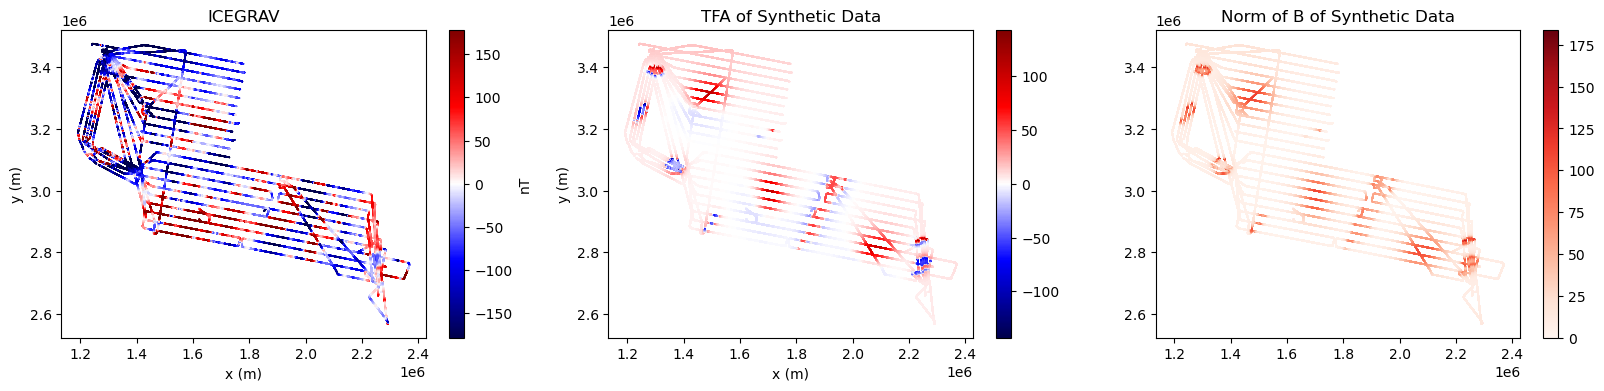

In [5]:
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
scale = np.nanpercentile(icegrav.MagL, 95)
plt.scatter(*coordinates[:2], c=icegrav.MagL, cmap="seismic",s=0.01, vmin=-scale, vmax=scale)
plt.title("ICEGRAV")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.colorbar(label="nT")
plt.subplot(1,3,2)
scale = vd.maxabs(icegrav_synthetic.tfa)
plt.scatter(*coordinates[:2], c=icegrav_synthetic.tfa, cmap="seismic",s=0.01, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.colorbar()
plt.subplot(1,3,3)
scale = vd.maxabs(icegrav_synthetic.bnorm)
plt.scatter(*coordinates[:2], c=icegrav_synthetic.bnorm, cmap="Reds",s=0.01, vmin=0, vmax=scale)
plt.title("Norm of B of Synthetic Data")
plt.colorbar()
plt.show()

## Fit deep sources

In [6]:
region = vd.get_region(coordinates)
spacing = 5e4
reducer = vd.BlockReduce(reduction=np.median, spacing=spacing, region=(vd.pad_region(region, pad=spacing*0.5)), drop_coords=False)
# Use the filter method to apply the reduction:
coords_blocked, tfa_blocked = reducer.filter(coordinates, data=icegrav_synthetic.tfa)

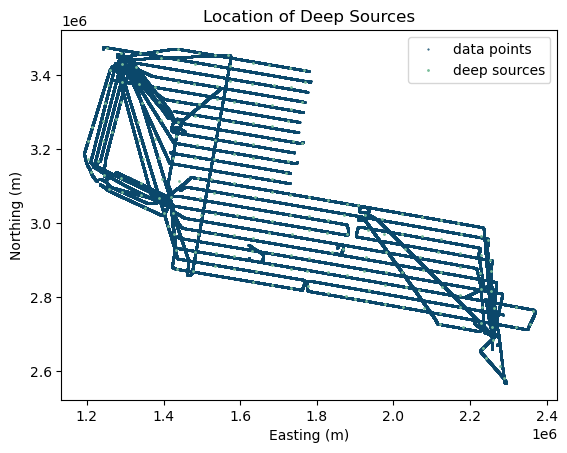

In [7]:
plt.figure()
plt.plot(*coordinates[:2], ".", color="#0B486B", markersize=1, label='data points')
plt.plot(*coords_blocked[:2], ".", color="#79BD9A", markersize=2, label='deep sources')
plt.title("Location of Deep Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.legend()
plt.show()

In [8]:
# dampings_deep_eqs = [1e-2, 1e-1, 1e1, 1e2]
spacing = np.mean(vd.median_distance(coords_blocked))
# depths_deep_eqs = [spacing*2.5, spacing*3.5, spacing*4.25, spacing*5, spacing*6]
dampings_deep_eqs = [1e1]
depths_deep_eqs = [spacing*3.5]

In [9]:
parameter_sets_deep_eqs = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_deep_eqs, depths_deep_eqs)
]
print("Number of combinations:", len(parameter_sets_deep_eqs))

Number of combinations: 1


In [10]:
%%time
kfold = vd.BlockKFold(
    spacing=2500,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coords_blocked[:2])
scores = []
damping = []
source_depth = []
for parameters in parameter_sets_deep_eqs:    
    print(parameters)
    eqs_deep = eqs.EquivalentSourcesMagnetic(block_size=1e5, **parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_deep.fit(
            [c[train] for c in coords_blocked], 
            tfa_blocked[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_deep.predict([c[test] for c in coords_blocked]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_blocked[test] - predicted))
    scores.append(np.mean(tmp))
    damping.append(parameters['damping'])
    source_depth.append(parameters['depth'])

{'damping': 10.0, 'depth': 128491.52143586782}
CPU times: user 4.76 s, sys: 844 ms, total: 5.61 s
Wall time: 1.14 s


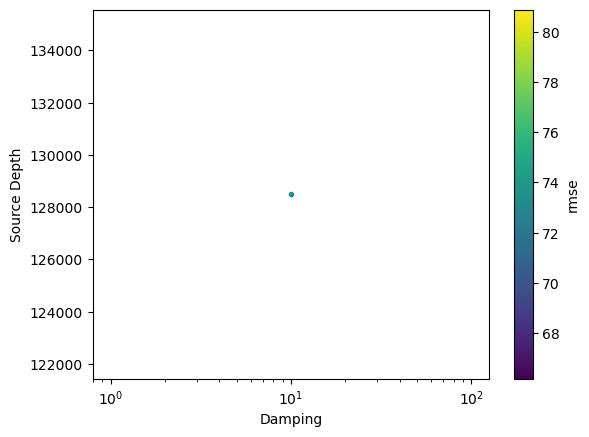

In [11]:
plt.figure()
plt.scatter(
    damping,
    source_depth,
    c=scores,
    cmap="viridis",
    marker='.',
    vmax= np.percentile(scores,40),
)
plt.xlabel('Damping')
plt.ylabel('Source Depth')
plt.xscale('log')
plt.colorbar(label='rmse')
plt.show()

In [12]:
best = np.argmin(scores)
parameter_sets_deep_eqs[best]

{'damping': 10.0, 'depth': 128491.52143586782}

In [13]:
%%time
eqs_deep = eqs.EquivalentSourcesMagnetic(block_size=1e5, **parameter_sets_deep_eqs[best])
eqs_deep.fit(coords_blocked, tfa_blocked, field_direction)
print("source height:", eqs_deep.dipole_coordinates_[2][0])

source height: -125609.42143586781
CPU times: user 507 ms, sys: 37.7 ms, total: 545 ms
Wall time: 19.6 ms


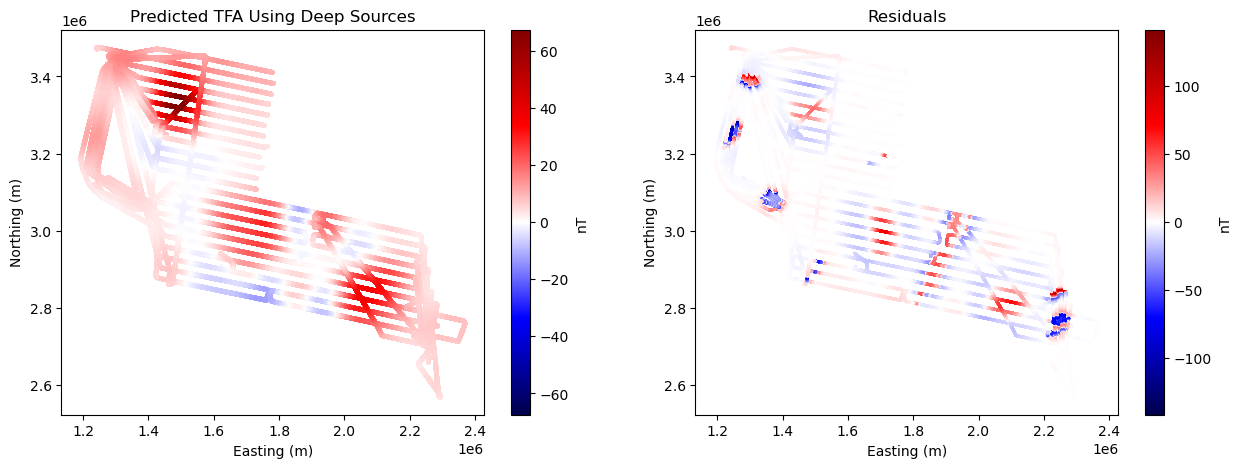

In [14]:
tfa_deep_blocked = eqs.total_field_anomaly(eqs_deep.predict(coords_blocked), field_direction)
tfa_deep = eqs.total_field_anomaly(eqs_deep.predict(coordinates), field_direction)
tfa_residuals = icegrav_synthetic.tfa - tfa_deep

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
scale = vd.maxabs(tfa_deep)
plt.scatter(*coordinates[:2], c=tfa_deep, cmap="seismic", s=5, vmin=-scale, vmax=scale)
plt.title("Predicted TFA Using Deep Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
scale = vd.maxabs(tfa_residuals)
plt.scatter(*coordinates[:2], c=tfa_residuals, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Residuals")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Fit the deep residuals with gradient-boosted sources

In [15]:
dampings_shallow_eqs = [1e2, 1e3, 1e4]
depths_shallow_eqs = [25e3, 26e3, 27e3]

In [16]:
parameter_sets_shallow_eqs = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_shallow_eqs, depths_shallow_eqs)
]
print("Number of combinations:", len(parameter_sets_shallow_eqs))

Number of combinations: 9


In [17]:
%%time
kfold = vd.BlockKFold(
    spacing=1e5,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores = []
damping = []
source_depth = []
for parameters in parameter_sets_shallow_eqs:    
    print(parameters)
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=1e3, window_size=1e4, **parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            tfa_residuals[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_residuals[test] - predicted))
    scores.append(np.mean(tmp))
    damping.append(parameters['damping'])
    source_depth.append(parameters['depth'])

{'damping': 100.0, 'depth': 25000.0}
{'damping': 100.0, 'depth': 26000.0}
{'damping': 100.0, 'depth': 27000.0}
{'damping': 1000.0, 'depth': 25000.0}
{'damping': 1000.0, 'depth': 26000.0}
{'damping': 1000.0, 'depth': 27000.0}
{'damping': 10000.0, 'depth': 25000.0}
{'damping': 10000.0, 'depth': 26000.0}
{'damping': 10000.0, 'depth': 27000.0}
CPU times: user 1d 7h 11min 5s, sys: 1h 48min 27s, total: 1d 8h 59min 32s
Wall time: 56min 20s


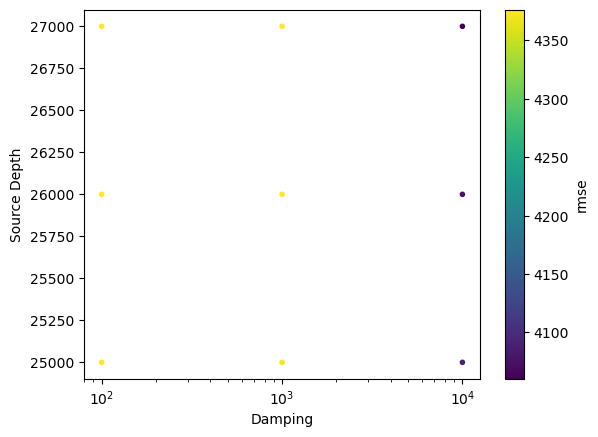

In [18]:
plt.figure()
plt.scatter(
    damping,
    source_depth,
    c=scores,
    cmap="viridis",
    marker='.',
    vmax= np.percentile(scores,40),
)
plt.xlabel('Damping')
plt.ylabel('Source Depth')
plt.xscale('log')
plt.colorbar(label='rmse')
plt.show()

In [19]:
best = np.argmin(scores)
parameter_sets_shallow_eqs[best]

{'damping': 10000.0, 'depth': 27000.0}

In [20]:
%%time
eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=1e3, window_size=1e4, **parameter_sets_shallow_eqs[best], repeat=2)
eqs_shallow.fit(coordinates, tfa_residuals, field_direction)
print("dipole height:", eqs_shallow.dipole_coordinates_[2][0])
print("window size:", eqs_shallow.window_size_)

dipole height: -24100.5
window size: 10000.0
CPU times: user 1h 56min 20s, sys: 5min 52s, total: 2h 2min 13s
Wall time: 3min 26s


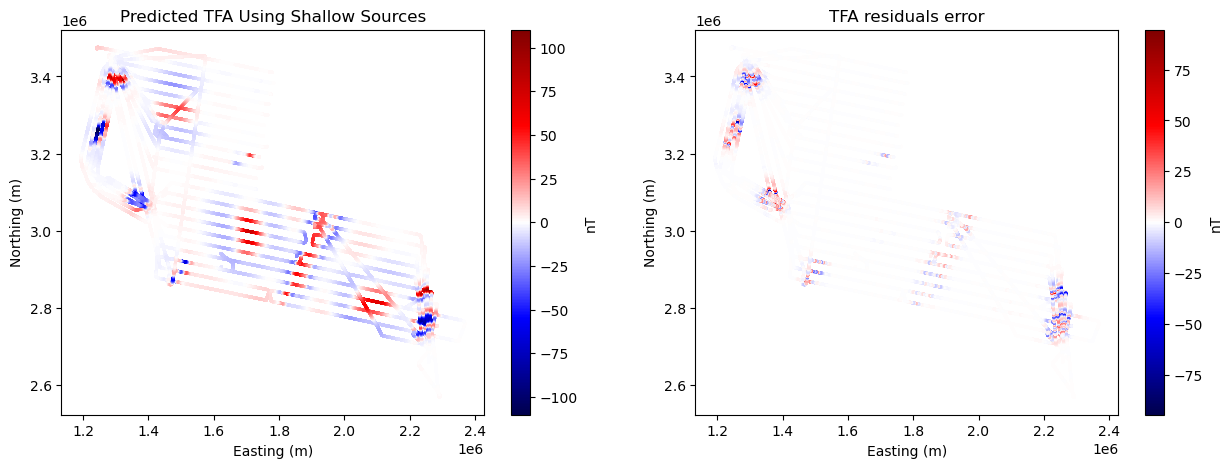

In [21]:
tfa_residuals_prediction = eqs.total_field_anomaly(eqs_shallow.predict(coordinates), field_direction)

plt.figure(figsize=(15,5))
scale = vd.maxabs(tfa_residuals_prediction)
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa_residuals_prediction, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Predicted TFA Using Shallow Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
scale = vd.maxabs(tfa_residuals - tfa_residuals_prediction)
plt.scatter(*coordinates[:2], c=tfa_residuals - tfa_residuals_prediction, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("TFA residuals error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Predict on a regular grid

In [22]:
grid_coordinates = vd.grid_coordinates(vd.get_region(coordinates), spacing=1e3, extra_coords=3e3)
mask = vd.distance_mask(data_coordinates=coordinates, maxdist=5e4, coordinates=grid_coordinates)
# mask = vd.convexhull_mask(coordinates, grid_coordinates)
grid_coords_masked = (
    np.array((xr.DataArray(grid_coordinates[0])).where(mask, drop=False)),
    np.array((xr.DataArray(grid_coordinates[1])).where(mask, drop=False)),
    np.array((xr.DataArray(grid_coordinates[2])).where(mask, drop=False))
)

In [23]:
true_b = eqs.dipole_magnetic(grid_coords_masked, source_coordinates, dipole_moments)
true_tfa = eqs.total_field_anomaly(true_b, field_direction)

predicted_b = eqs_deep.predict(grid_coords_masked) + eqs_shallow.predict(grid_coords_masked)
predicted_tfa = eqs.total_field_anomaly(predicted_b, field_direction)
error_tfa = true_tfa - predicted_tfa
rmse_tfa = np.sqrt(np.square(~np.isnan(error_tfa)).mean())

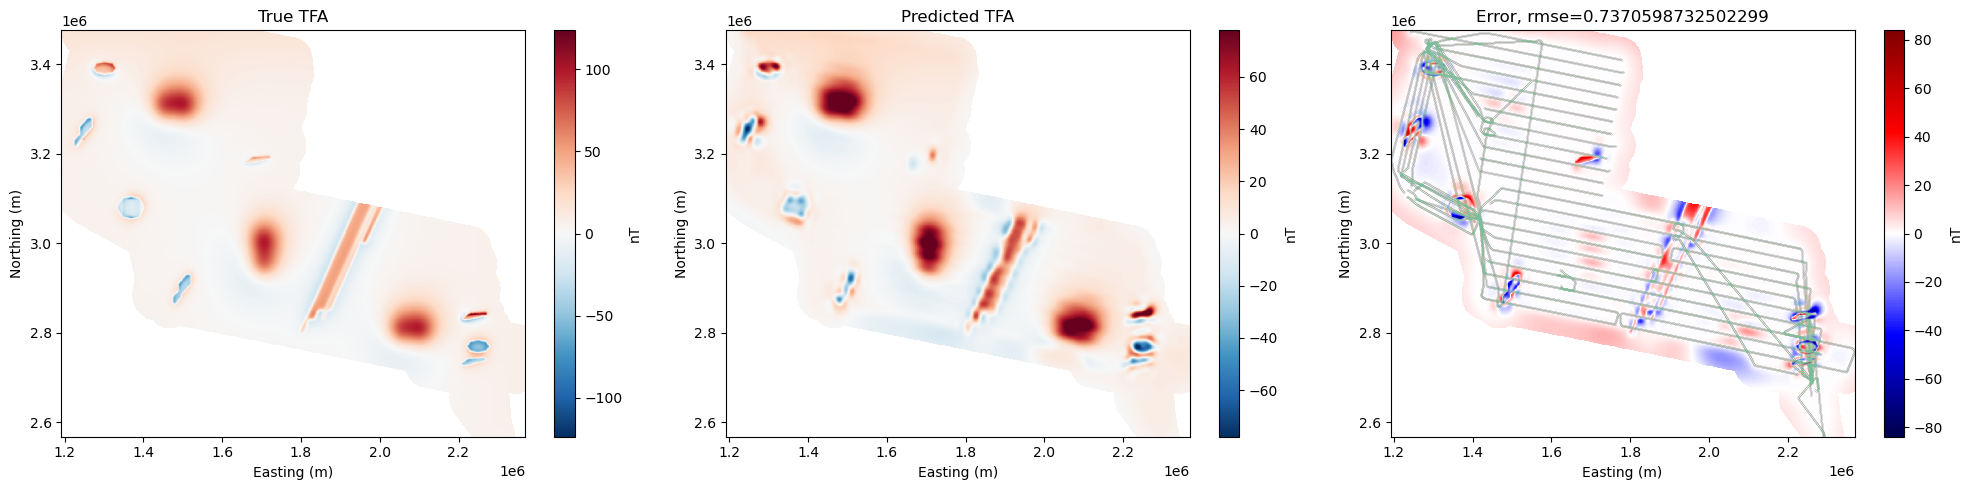

In [24]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
scale = vd.maxabs(true_tfa)
plt.pcolormesh(*grid_coordinates[:2], true_tfa, cmap="RdBu_r", vmin=-scale, vmax=scale)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
scale = np.nanpercentile(predicted_tfa, 99)
plt.pcolormesh(*grid_coordinates[:2], predicted_tfa, cmap="RdBu_r", vmin=-scale, vmax=scale)
plt.title("Predicted TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
scale = vd.maxabs(error_tfa)
plt.pcolormesh(*grid_coordinates[:2], error_tfa, cmap="seismic", vmin=-scale, vmax=scale)
plt.plot(*coordinates[:2], ".", color="#79BD9A", markersize=0.004, label='deep sources')
plt.title('Error, rmse={}'.format(rmse_tfa))
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()

In [25]:
true_bnorm = np.sqrt(sum(c**2 for c in true_b))
predicted_bnorm = np.sqrt(sum(c**2 for c in predicted_b))
error_bnorm = true_bnorm - predicted_bnorm
rmse_bnorm = np.sqrt(np.square(~np.isnan(error_bnorm)).mean())

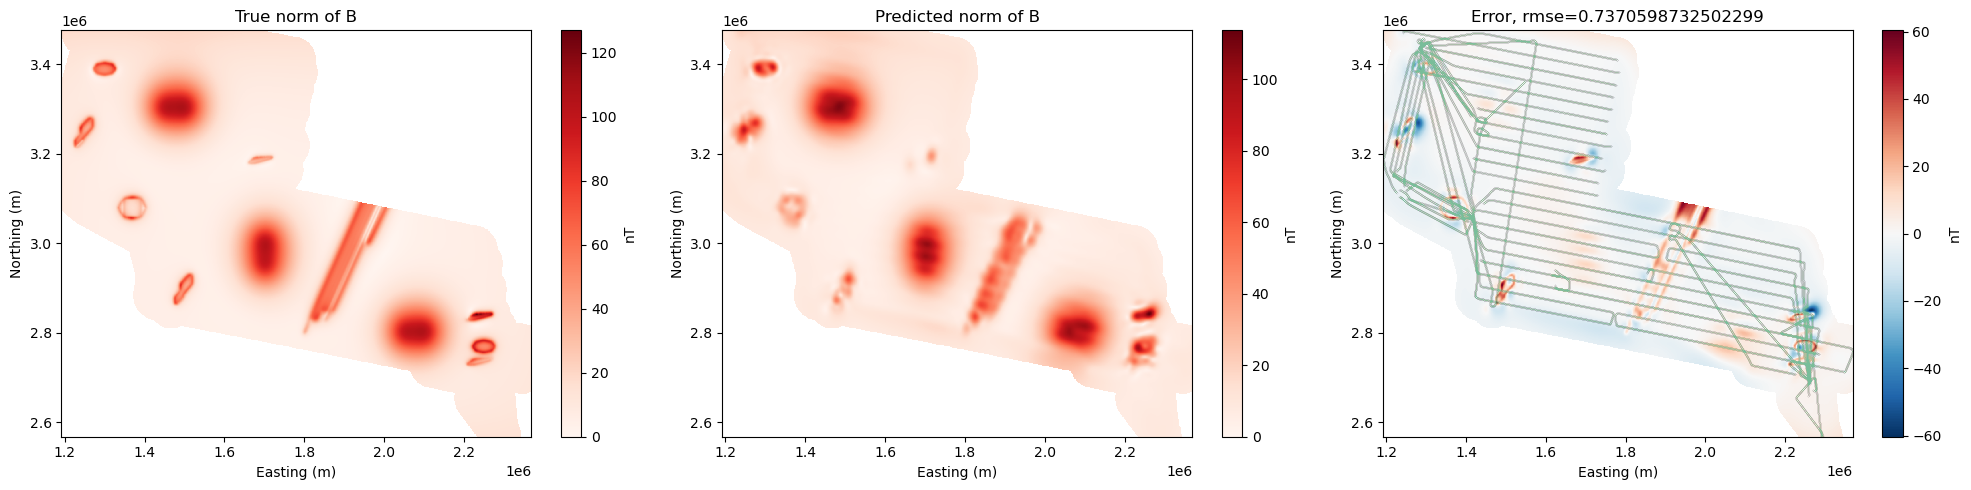

In [26]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
scale = vd.maxabs(true_bnorm)
plt.pcolormesh(*grid_coordinates[:2], true_bnorm, cmap="Reds", vmin=0, vmax=scale)
plt.title("True norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
scale = vd.maxabs(predicted_bnorm)
plt.pcolormesh(*grid_coordinates[:2], predicted_bnorm, cmap="Reds", vmin=0, vmax=scale)
plt.title("Predicted norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
scale = vd.maxabs(error_bnorm)
plt.pcolormesh(*grid_coordinates[:2], error_bnorm, cmap="RdBu_r", vmin=-scale, vmax=scale)
plt.plot(*coordinates[:2], ".", color="#79BD9A", markersize=0.004, label='deep sources')
plt.title('Error, rmse={}'.format(rmse_bnorm))
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()